# Language Modeling


Let's try the language modeling task by using chariot and Tensorflow.

* Download the WikiText2 dataset by chazutsu.
* Preprocess WikiText2 by chariot.
* Make model by TensorFlow (use tf.keras).
* Train & evaluate the model.

This tutorial needs following libraries.

* chazutsu
* tensorflow
* matplotlib


## Prepare the packages

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def set_path():
    if "../" not in sys.path:
        sys.path.append("../")
    root_dir = Path.cwd()
    return root_dir

ROOT_DIR = set_path()

## Download the Language Modeling Data

In [4]:
import chazutsu
from chariot.storage import Storage

storage = Storage.setup_data_dir(ROOT_DIR)
r = chazutsu.datasets.WikiText2().download(storage.data_path("raw"))

Read resource from the existed resource(if you want to retry, set force=True).


In [5]:
r.train_data().head(3)

,sentence
0,= Valkyria Chronicles III =
1,Senjō no Valkyria 3 : <unk> Chronicles ( Japa...
2,"The game began development in 2010 , carrying..."


## Preprocess the review text by chariot.

### Make preprocessor

In [6]:
import chariot.transformer as ct
from chariot.preprocessor import Preprocessor


lm_processor = Preprocessor(
                    text_transformers=[
                        ct.text.UnicodeNormalizer(),
                        ct.text.LowerNormalizer()
                    ],
                    tokenizer=ct.Tokenizer(lang=None),
                    vocabulary=ct.Vocabulary(min_df=5))

preprocessed = lm_processor.fit_transform(r.valid_data())

In [7]:
print(len(lm_processor.vocabulary.get()))

4321


## Make model by TensorFlow

In [8]:
from tensorflow.python import keras as K


vocab_size = lm_processor.vocabulary.count
embedding_size = 100
hidden_size = 100
batch_size = 20
sequence_length = 35


def make_model(vocab_size, embedding_size, hidden_size, dropout=0.5):
    initializer = K.initializers.RandomUniform(minval=-0.1, maxval=0.1)
    model = K.Sequential()
    model.add(K.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size,
                                 embeddings_initializer=initializer))
    model.add(K.layers.Dropout(dropout))
    model.add(K.layers.LSTM(hidden_size, return_sequences=True))
    model.add(K.layers.Dropout(dropout))
    model.add(K.layers.TimeDistributed(K.layers.Dense(vocab_size, activation="softmax",
                                       kernel_initializer=initializer)))
    return model


def perplexity(y_true, y_pred):
    cross_entropy = K.backend.mean(K.backend.sparse_categorical_crossentropy(y_true, y_pred))
    perplexity = K.backend.exp(cross_entropy)
    return perplexity

In [9]:
model = make_model(vocab_size, embedding_size, hidden_size)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=[perplexity])

## Train the Model

In [10]:
class ReportCallback(K.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        print("Epoch {}: perplexity={}, loss={}, val_perplexity={}, val_loss={},".format(
                epoch, logs["perplexity"], logs["loss"], logs["val_perplexity"], logs["val_loss"]))

In [11]:
from chariot.feeder import LanguageModelFeeder


generator_step = {"valid":{}, "test": {}}
for kind in generator_step:
    if kind == "valid":
        data = preprocessed
    else:
        data = lm_processor.transform(r.test_data())

    feeder = LanguageModelFeeder({"sentence": ct.formatter.ShiftGenerator()})
    steps_per_epoch, generator = feeder.make_generator(data, batch_size=batch_size,
                                                       sequence_length=sequence_length,
                                                       sequencial=False)
    generator_step[kind]["s"] = steps_per_epoch
    generator_step[kind]["g"] = generator()

In [12]:
metrics = model.fit_generator(generator_step["valid"]["g"], generator_step["valid"]["s"],
                              validation_data=generator_step["test"]["g"], validation_steps=generator_step["valid"]["s"],
                              epochs=10, verbose=0, callbacks=[ReportCallback()])

c:\users\tie301837\works\source\chariot\venv\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 0: perplexity=410.3856207925765, loss=5.532460450344399, val_perplexity=104.70021209716796, val_loss=4.638861593652944,
Epoch 1: perplexity=178.488554307281, loss=5.174011355540792, val_perplexity=100.51167642562116, val_loss=4.598064771245737,
Epoch 2: perplexity=169.26421866495102, loss=5.120777248945393, val_perplexity=96.7481261206455, val_loss=4.560221617339088,
Epoch 3: perplexity=159.73605651855468, loss=5.0629764775760835, val_perplexity=94.59693552236088, val_loss=4.537517164574295,
Epoch 4: perplexity=151.62092928026544, loss=5.01111572296893, val_perplexity=93.4989170512215, val_loss=4.526635920415159,
Epoch 5: perplexity=146.53029717617346, loss=4.977219223585285, val_perplexity=91.51708809274142, val_loss=4.505033760383481,
Epoch 6: perplexity=141.9752218027584, loss=4.945905704185611, val_perplexity=89.93637321347096, val_loss=4.487005688714199,
Epoch 7: perplexity=138.48216915443297, loss=4.920829580650955, val_perplexity=88.20428171626857, val_loss=4.4683843409428

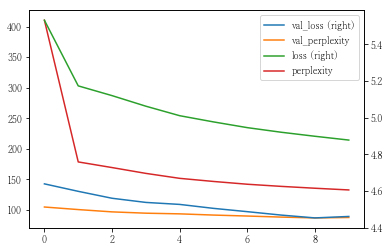

In [13]:
result = pd.DataFrame.from_dict(metrics.history)
result.plot.line(secondary_y=["loss", "val_loss"])

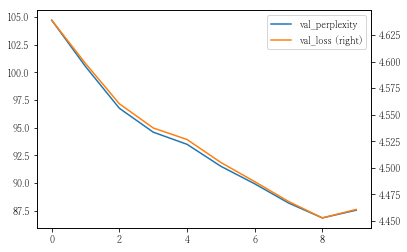

In [14]:
result[["val_perplexity", "val_loss"]].plot.line(secondary_y=["val_loss"])

## Try generating the Text

In [15]:
def generate_text(seed_text, lm_processor, model, sequence_length=10, iteration=20):
    preprocessed = lm_processor.transform([seed_text])[0]

    def pad_sequence(tokens, length):
        if len(tokens) < length:
            pad_size = length - len(tokens)
            return tokens + [lm_processor.vocabulary.pad] * pad_size
        elif len(tokens) > length:
            return tokens[-length:]
        else:
            return tokens

    for _ in range(iteration):
        x = pad_sequence(preprocessed, sequence_length)
        y = model.predict([x])
        index = min(len(preprocessed) - 1, sequence_length - 1)
        target_word_probs = y[index][0]
        w = np.random.choice(np.arange(len(target_word_probs)),
                             1, p=target_word_probs)[0]
        preprocessed.append(w)
    
    decoded = lm_processor.inverse_transform([preprocessed])
    text = " ".join(decoded[0])

    return text

In [16]:
generate_text("when you", lm_processor, model)

'when you floor as @@UNKNOWN@@ decade @@UNKNOWN@@ @@UNKNOWN@@ causing united lord south @@UNKNOWN@@ upright out @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ this have 21 speech'

In [17]:
generate_text("i wish to", lm_processor, model)

"i wish @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ playing 's boy @@UNKNOWN@@ for farrell act @@UNKNOWN@@ km 1798 thames @@UNKNOWN@@ all better terms michael structure"

## Stateful Pattern

In [18]:
def make_model_stateful(vocab_size, embedding_size, hidden_size, batch_shape, dropout=0.5):
    initializer = K.initializers.RandomUniform(minval=-0.1, maxval=0.1)
    model = K.Sequential()
    model.add(K.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size,
                                 embeddings_initializer=initializer,
                                 batch_input_shape=batch_shape))
    model.add(K.layers.Dropout(dropout))
    model.add(K.layers.LSTM(hidden_size, stateful=True, return_sequences=True))
    model.add(K.layers.Dropout(dropout))
    model.add(K.layers.TimeDistributed(K.layers.Dense(vocab_size, activation="softmax",
                                       kernel_initializer=initializer)))
    return model

In [19]:
model_s = make_model_stateful(vocab_size, embedding_size, hidden_size, (batch_size, sequence_length))
model_s.compile(loss="sparse_categorical_crossentropy",
               optimizer="adam",
               metrics=[perplexity])

In [20]:
metrics_s = model_s.fit_generator(generator_step["valid"]["g"], generator_step["valid"]["s"],
                                  validation_data=generator_step["test"]["g"], validation_steps=generator_step["valid"]["s"],
                                  epochs=10, verbose=0, callbacks=[ReportCallback()])

c:\users\tie301837\works\source\chariot\venv\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 0: perplexity=359.9346899564149, loss=5.375408962124684, val_perplexity=95.72728484106845, val_loss=4.5489686012268065,
Epoch 1: perplexity=158.796647093726, loss=5.057217143011875, val_perplexity=93.635550489582, val_loss=4.526964501865574,
Epoch 2: perplexity=148.11312195824794, loss=4.988003446235031, val_perplexity=90.92516085515257, val_loss=4.498757146616451,
Epoch 3: perplexity=139.8941340211962, loss=4.931109206402888, val_perplexity=87.35910518208487, val_loss=4.458968536189345,
Epoch 4: perplexity=133.14641613569415, loss=4.881728893029885, val_perplexity=84.43592426737801, val_loss=4.425346147818644,
Epoch 5: perplexity=127.85487931048284, loss=4.841562213272345, val_perplexity=83.28317837324299, val_loss=4.411346337052643,
Epoch 6: perplexity=123.51651996550012, loss=4.806883091223044, val_perplexity=82.15688814257012, val_loss=4.398415971974858,
Epoch 7: perplexity=119.46718432317014, loss=4.773762262062948, val_perplexity=79.8147964602611, val_loss=4.368951739639533

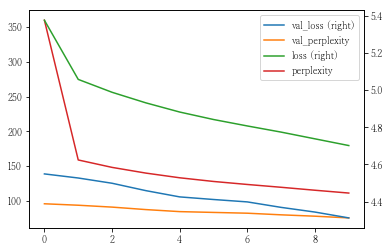

In [21]:
result_s = pd.DataFrame.from_dict(metrics_s.history)
result_s.plot.line(secondary_y=["loss", "val_loss"])

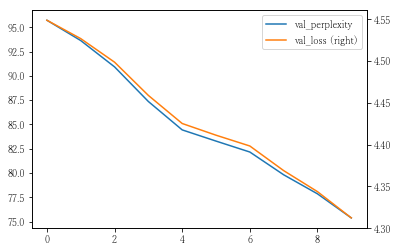

In [22]:
result_s[["val_perplexity", "val_loss"]].plot.line(secondary_y=["val_loss"])

In [23]:
generate_text("champion", lm_processor, model)

'champion maintaining was i cast ( film attempts @@UNKNOWN@@ fuel board per norway @@UNKNOWN@@ on @@UNKNOWN@@ i attempting @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@'